In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import Tensor
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, \
                         AveragePooling1D, GlobalAveragePooling1D, \
                         Add, BatchNormalization, ReLU, Input
                         
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters



# plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
%matplotlib widget
# %matplotlib inline

tf.random.set_seed(18)
np.random.seed(48)

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Data Import

In [3]:
with open('_pickles/exp_validation_data.pickle', 'rb') as f:
    ex_val_data = pickle.load(f)
with open('_pickles/exp_validation_labels.pickle', 'rb') as f:
    ex_val_labels = pickle.load(f)
with open('_pickles/exp_validation_trails.pickle', 'rb') as f:
    ex_val_trails = pickle.load(f)

with open('_pickles/exp_val_resample.pickle', 'rb') as f:
    ex_val_resample = pickle.load(f)
with open('_pickles/exp_val_norm_labels.pickle', 'rb') as f:
    ex_val_norm_labels = pickle.load(f)

In [4]:
with open('_pickles/train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)

with open('_pickles/train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)

with open('_pickles/training_labels.pickle', 'rb') as f:
    training_labels = pickle.load(f)

X = np.array(train_resample)
y = training_labels

scalar = MinMaxScaler()
y_norm = scalar.fit_transform(training_labels)

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

(925, 100, 4) (925, 2)
Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


#### Other Networks

##### ResNet

In [28]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(i)
    return j


def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
        
    num_blocks_list = [2, 4, 2]
    for j in range(num_blocks_list[0]):
        t = residual_block(t, filters=num_filters)
        
    t = CNN_block(t, filters = 256)
    for j in range(num_blocks_list[1]):
        t = residual_block(t, filters=256)
    
    t = CNN_block(t, filters = 64)
    for j in range(num_blocks_list[2]):
        t = residual_block(t, filters=64)


    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    t = Dense(units=128, activation='relu')(t)
    t1 = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t1)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['Accuracy']
    )

    return model

model = create_res_net() # or create_plain_net()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 4)]     0           []                               
                                                                                                  
 batch_normalization_161 (Batch  (None, 100, 4)      16          ['input_13[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 conv1d_131 (Conv1D)            (None, 100, 64)      832         ['batch_normalization_161[0][0]']
                                                                                                  
 re_lu_130 (ReLU)               (None, 100, 64)      0           ['conv1d_131[0][0]']       

In [29]:
# timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

# checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.system('mkdir {}'.format(checkpoint_dir))

# # save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

rNet_history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=32,
    # callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/30
26/26 [==============================] - 18s 497ms/step - loss: 0.3009 - Accuracy: 0.5577 - val_loss: 0.2061 - val_Accuracy: 0.5269
Epoch 2/30
26/26 [==============================] - 10s 384ms/step - loss: 0.0857 - Accuracy: 0.6683 - val_loss: 0.1787 - val_Accuracy: 0.5054
Epoch 3/30
26/26 [==============================] - 10s 390ms/step - loss: 0.0413 - Accuracy: 0.8161 - val_loss: 0.1723 - val_Accuracy: 0.4839
Epoch 4/30
26/26 [==============================] - 10s 378ms/step - loss: 0.0252 - Accuracy: 0.8582 - val_loss: 0.1751 - val_Accuracy: 0.4624
Epoch 5/30
26/26 [==============================] - 8s 327ms/step - loss: 0.0222 - Accuracy: 0.8570 - val_loss: 0.1711 - val_Accuracy: 0.4624
Epoch 6/30
26/26 [==============================] - 9s 364ms/step - loss: 0.0134 - Accuracy: 0.8846 - val_loss: 0.1478 - val_Accuracy: 0.5699
Epoch 7/30
26/26 [==============================] - 9s 347ms/step - loss: 0.0106 - Accuracy: 0.8930 - val_loss: 0.1404 - val_Accuracy: 0.6344
Ep

In [30]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(model.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wresnet.predict(x_test)))

116.75226881536804

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
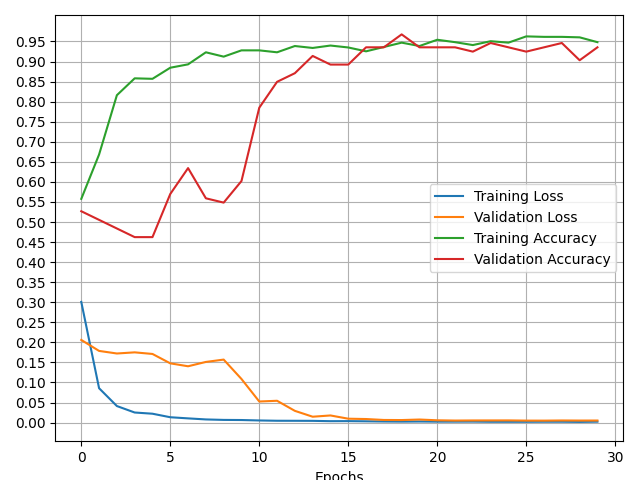

In [31]:
plt.close()
plt.plot(rNet_history.history['loss'], label='Training Loss')
plt.plot(rNet_history.history['val_loss'], label='Validation Loss')
plt.plot(rNet_history.history['Accuracy'], label='Training Accuracy')
plt.plot(rNet_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

##### Wide ResNet

In [ ]:
# Wide ResNet Architecture
# https://arxiv.org/pdf/1605.07146.pdf
#

# wrNet

In [42]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wresnet.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wresnet.predict(x_test)))

28.03245639619143

In [ ]:
# wresnet.save(f'model/wresnet_CNN_val_acc_97_16_MSE.{int(time.time())}.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
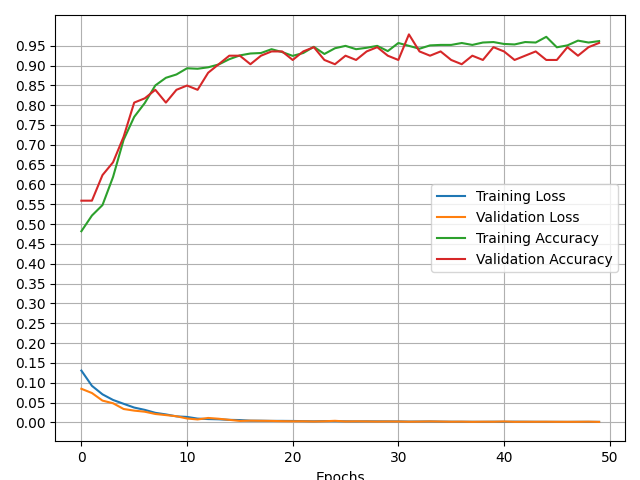

In [43]:
plt.close()
plt.plot(wresnet_history.history['loss'], label='Training Loss')
plt.plot(wresnet_history.history['val_loss'], label='Validation Loss')
plt.plot(wresnet_history.history['Accuracy'], label='Training Accuracy')
plt.plot(wresnet_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Predict experimental data validation

In [ ]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('Alex3.h5')
# model = tf.keras.models.load_model('model/CNN_val_acc_96_48_MSEperAcc.1642513870.h5')
# model.summary()

In [44]:
y_pred = wresnet.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels

y_pred = scalar.inverse_transform(np.asarray(y_pred))
diff = y_abs-y_pred
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

Absolute Trial 1.0- [205. 200.] Predicted - [211.2933  229.10872] 	Difference - [ -6.29330444 -29.10871887]
Absolute Trial 2.0- [205. 200.] Predicted - [209.50313 232.2028 ] 	Difference - [ -4.50312805 -32.20280457]
Absolute Trial 3.0- [205. 200.] Predicted - [213.53163 235.98428] 	Difference - [ -8.53163147 -35.98428345]
Absolute Trial 4.0- [205. 200.] Predicted - [212.25783 226.2775 ] 	Difference - [ -7.25782776 -26.27749634]
Absolute Trial 1.0- [225. 210.] Predicted - [208.67899 247.67882] 	Difference - [ 16.3210144  -37.67881775]
Absolute Trial 2.0- [225. 210.] Predicted - [216.1876  228.32698] 	Difference - [  8.81239319 -18.32698059]
Absolute Trial 3.0- [225. 210.] Predicted - [215.23532 237.3637 ] 	Difference - [  9.76467896 -27.36369324]
Absolute Trial 4.0- [225. 210.] Predicted - [214.27765 241.47389] 	Difference - [ 10.72235107 -31.47389221]
Absolute Trial 1.0- [230. 245.] Predicted - [239.28006 237.21573] 	Difference - [-9.28005981  7.78427124]
Absolute Trial 2.0- [230. 245.

In [45]:
mean_squared_error(y_abs, y_pred, squared=True)
mean_absolute_error(y_abs, y_pred)

18.70236810048421